In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [148]:
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns


In [149]:
# Globals
SAMPLE = 'testis2'
fname = f'../output/cellselection-wf/grid_search/{SAMPLE}/{SAMPLE}_1000_4000_20_2_clusters.feather'
INPUTS = Path(fname).parent.glob("*.feather")

OUTPUT = '../output/notebook/2019-06-18_cellselection_grid_search.svg'


In [150]:
# Get all cluster calls
def get_data(fname: Path):
    name = "_".join(fname.stem.split("_")[1:5])

    return (
        pd.read_feather(fname, columns=["cell_id", "cluster"])
        .rename(columns={"cluster": name})
        .set_index("cell_id")
        .squeeze()
    )


df = pd.concat((get_data(x) for x in INPUTS), axis=1, sort=True).dropna()


In [151]:
# Calculate the pairwise adjsusted RAND Score
res = (
    pd.DataFrame(
        [
            (c1, c2, metrics.adjusted_rand_score(df[c1], df[c2]))
            for c1, c2 in product(df.columns, df.columns)
        ],
        columns=["c1", "c2", "AdjRand"],
    )
    .set_index(["c1", "c2"])
    .sort_index()
    .unstack()
)

res.columns = res.columns.droplevel(0)


In [152]:
# Get row and col ordering based on numeric representation of names
def make_numeric(x):
    if x == "None":
        return np.nan
    else:
        return int(x)


idx_order = (
    pd.DataFrame(index=res.index)
    .assign(low=lambda x: x.index.str.extract("^(\d+)_.*", expand=False))
    .assign(high=lambda x: x.index.str.extract("^.*?_(\d+|None)_.*", expand=False))
    .assign(mito=lambda x: x.index.str.extract("^.*?_.*?_(\d+|None)_.*", expand=False))
    .assign(ribo=lambda x: x.index.str.extract("^.*?_.*?_.*?_(\d+|None)", expand=False))
    .applymap(make_numeric)
    .sort_values(["low", "high", "mito", "ribo"])
    .index
)



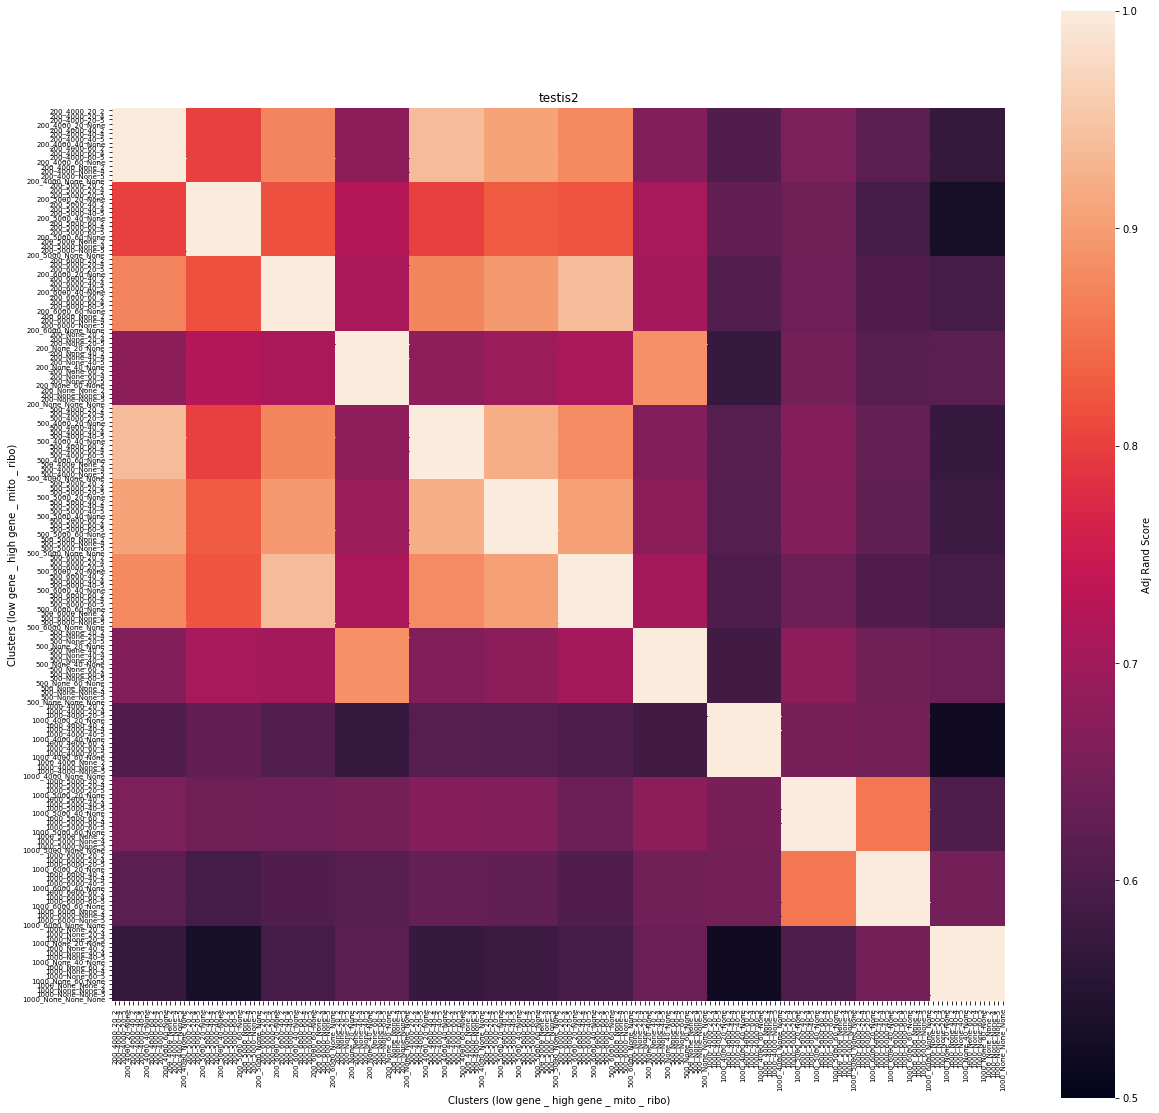

In [154]:
# Plot cluster map of RAND Scores

fig = plt.figure(figsize=(20, 20))
ax = sns.heatmap(
    res.reindex(idx_order).reindex(idx_order.values, axis=1),
    xticklabels=True,
    yticklabels=True,
    square=True,
    vmin=0.5,
    vmax=1,
    cbar_kws={'label': "Adj Rand Score"}
)
ax.set(
    xlabel="Clusters (low gene _ high gene _ mito _ ribo)",
    ylabel="Clusters (low gene _ high gene _ mito _ ribo)",
    title=SAMPLE
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

plt.savefig(OUTPUT)
